# Gaussian Weight Regularization

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import time
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model baseline

In [2]:
batch_size = 32
global_step = 0
save_path = 'models/gauss.ckpt'
xlen = 28*28
ylen = 10
reg_param = 0.5

train_steps = 150000
info_every = 250
test_every = 1000

## Build model

In [3]:
def gaussian(X, mu, sigma):
    x_mu = tf.sub(X, mu)
    Z = tf.square(tf.div(x_mu, sigma))
    power_e = tf.exp(tf.div(-Z,2*sigma**2))
    regularize_term = np.sqrt(2*np.pi)*sigma
    gaussian = tf.div(power_e, regularize_term)
    return gaussian

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

gauss_param = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, shape=[None, xlen], name="x")
noise_source = tf.placeholder(tf.float32, shape=[xlen, ylen], name="noise_source")
y_ = tf.placeholder(tf.float32, shape=[None, ylen], name="y_")
init = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=1234, dtype=tf.float32)

S_hat = tf.get_variable("S_hat", shape=[xlen,ylen], initializer=init)
S = tf.exp(S_hat)

mu = tf.get_variable("mu", shape=[xlen,ylen], initializer=init)
W = gaussian(noise_source*gauss_param, mu, S)

output = tf.nn.softmax(tf.matmul(x, W))

In [5]:
loss = tf.nn.l2_loss( y_ - output ) / (ylen*batch_size)

optimizer = tf.train.AdamOptimizer(1e-3)
grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables())
train_op = optimizer.apply_gradients(grads)

sess.run(tf.initialize_all_variables())

## Model overview

In [6]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "S_hat:0" has 7840 parameters
	variable "mu:0" has 7840 parameters
Total of 15680 parameters


## Train

In [7]:
correct_prediction = tf.equal(tf.argmax(output,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
loss_curve = np.zeros((train_steps/info_every, 2))
acc_curve = np.zeros((train_steps/test_every, 2))

normal_noise = np.random.randn(xlen*ylen)
begin = time.time()
for i in range(train_steps):
    batch_start = time.time()
    normal_noise = np.concatenate((normal_noise.ravel()[-2:-1], normal_noise.ravel()[:-1]))
    normal_noise = np.reshape(normal_noise, (xlen,ylen))
    
    batch = mnist.train.next_batch(batch_size)
    feed = {x: batch[0], y_: batch[1], noise_source: normal_noise, gauss_param: reg_param}
    train_loss, _ = sess.run([loss, train_op], feed_dict=feed)
    
    if i%test_every == 0:
        feed = {x: mnist.test.images, y_: mnist.test.labels, noise_source: normal_noise, gauss_param: 0}
        acc = accuracy.eval(feed_dict=feed)
        acc_curve[i/test_every,:] = [i, acc]
        print "{}/{}: test accuracy: {:3f}".format(i, train_steps, acc)
    if i%info_every == 0:
        loss_curve[i/info_every,:] = [i, train_loss]
        print "\tstep {}, loss {:3f}, batch time {:3f}".format(i, train_loss, time.time()-batch_start)
print "\ntotal runtime: {:3f} seconds".format(time.time()-begin)

0/150000: test accuracy: 0.153400
	step 0, loss 0.044123, batch time 0.060556
	step 250, loss 0.036197, batch time 0.001665
	step 500, loss 0.028683, batch time 0.001871
	step 750, loss 0.024250, batch time 0.001931
1000/150000: test accuracy: 0.832500
	step 1000, loss 0.018090, batch time 0.037667
	step 1250, loss 0.020973, batch time 0.002360
	step 1500, loss 0.015508, batch time 0.001952
	step 1750, loss 0.017284, batch time 0.001892
2000/150000: test accuracy: 0.868900
	step 2000, loss 0.023144, batch time 0.037593
	step 2250, loss 0.016483, batch time 0.001865
	step 2500, loss 0.015788, batch time 0.001732
	step 2750, loss 0.011171, batch time 0.001710
3000/150000: test accuracy: 0.878500
	step 3000, loss 0.016277, batch time 0.036597
	step 3250, loss 0.009924, batch time 0.001669
	step 3500, loss 0.011954, batch time 0.001546
	step 3750, loss 0.014359, batch time 0.001701
4000/150000: test accuracy: 0.883100
	step 4000, loss 0.009069, batch time 0.034196
	step 4250, loss 0.018011

In [22]:
feed = {x: mnist.test.images, y_: mnist.test.labels, noise_source: normal_noise, gauss_param: 0}
acc = accuracy.eval(feed_dict=feed)
print "final test accuracy: {:3f}".format(acc)

final test accuracy: 0.915200


## Plot performance

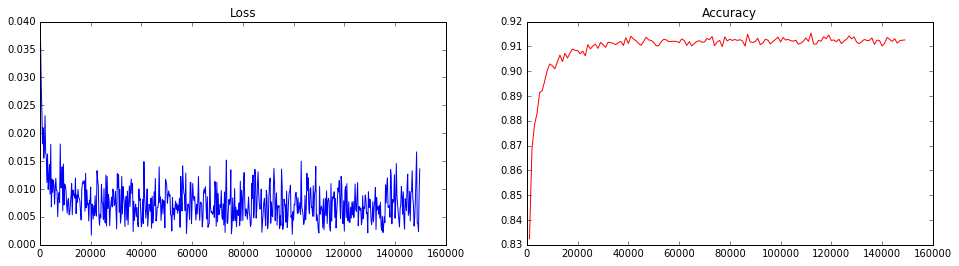

In [10]:
plt.figure(0, figsize=(16,4))
plt.subplot(121)
plt.title("Loss")
plt.plot(loss_curve[1:,0], loss_curve[1:,1], 'b-')
plt.subplot(122)
plt.title("Accuracy")
plt.plot(acc_curve[1:,0], acc_curve[1:,1], 'r-')

with open('gauss.p', 'w') as f:
    pickle.dump(acc_curve, f)

## Plot weights

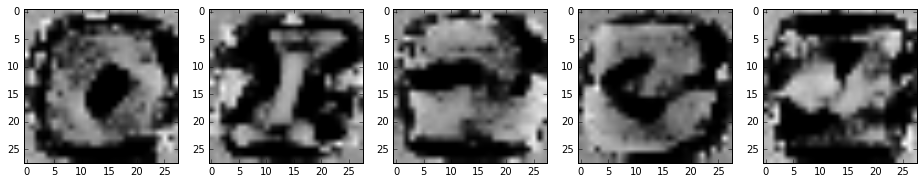

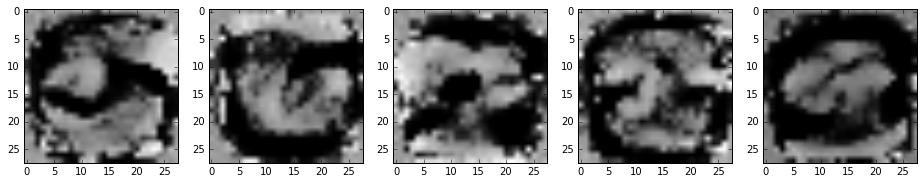

In [11]:
normal_noise = np.random.randn(xlen, ylen)
feed = {noise_source: normal_noise, gauss_param: 0}
W_ = W.eval(feed_dict=feed)

for i in range(0,10,5):
    img1 = np.reshape(W_[:,i], (28,28))
    img2 = np.reshape(W_[:,i+1], (28,28))
    img3 = np.reshape(W_[:,i+2], (28,28))
    img4 = np.reshape(W_[:,i+3], (28,28))
    img5 = np.reshape(W_[:,i+4], (28,28))
    plt.figure(i, figsize=(16,4))
    plt.subplot(151)
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152)
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153)
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154)
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155)
    plt.imshow(img5, cmap=cm.gray)

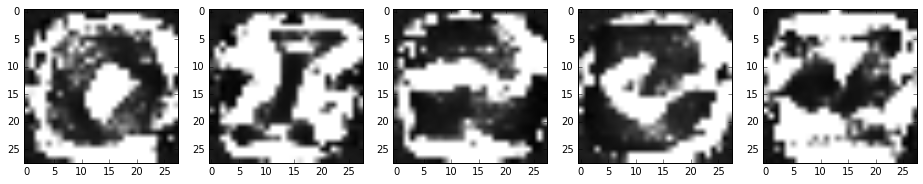

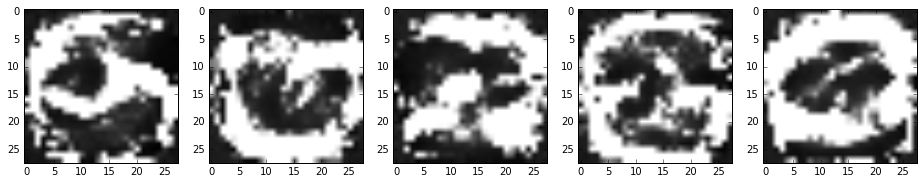

In [12]:
normal_noise = np.random.randn(xlen, ylen)
feed = {noise_source: normal_noise, gauss_param: 0}
S_ = S.eval(feed_dict=feed)
S_ = np.clip(S_,0,5)
for i in range(0,10,5):
    img1 = np.reshape(S_[:,i], (28,28))
    img2 = np.reshape(S_[:,i+1], (28,28))
    img3 = np.reshape(S_[:,i+2], (28,28))
    img4 = np.reshape(S_[:,i+3], (28,28))
    img5 = np.reshape(S_[:,i+4], (28,28))
    plt.figure(i, figsize=(16,4))
    plt.subplot(151)
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152)
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153)
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154)
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155)
    plt.imshow(img5, cmap=cm.gray)

In [13]:
print np.min(W_), np.max(W_), "\n", W_

1.15052e-06 0.797411 
[[ 0.38362896  0.40658948  0.37953022 ...,  0.38933724  0.41178477
   0.35187897]
 [ 0.43885198  0.39484674  0.36036855 ...,  0.35683849  0.3578321
   0.34337434]
 [ 0.38985217  0.40301123  0.41275877 ...,  0.36767     0.36992842
   0.39526299]
 ..., 
 [ 0.37643221  0.40680289  0.41744515 ...,  0.43124542  0.4051252
   0.3954227 ]
 [ 0.4114894   0.39450333  0.41274568 ...,  0.39349276  0.41217601
   0.38372904]
 [ 0.39516264  0.39263311  0.3884488  ...,  0.45330378  0.37757951
   0.38867572]]


In [14]:
print np.min(S_), np.max(S_), "\n", S_

0.487248 5.0 
[[ 1.03925633  0.98099685  1.05011463 ...,  1.02439988  0.96823853
   1.12864387]
 [ 0.90173328  1.01032138  1.1034286  ...,  1.11378086  1.11084843
   1.15506673]
 [ 1.02307379  0.98984998  0.96585655 ...,  1.08257174  1.07626247
   1.00926709]
 ..., 
 [ 1.05843747  0.98047072  0.95442367 ...,  0.92071128  0.98461229
   1.00886297]
 [ 0.96896154  1.01119208  0.9658885  ...,  1.01375949  0.9672814
   1.03899324]
 [ 1.00952113  1.01594949  1.02669311 ...,  0.86303389  1.05534315
   1.02610672]]


## Saver IO

In [15]:
# saver = tf.train.Saver(tf.all_variables())
# load_was_success = True # yes, I'm being optimistic
# try:
#     save_dir = '/'.join(save_path.split('/')[:-1])
#     ckpt = tf.train.get_checkpoint_state(save_dir)
#     load_path = ckpt.model_checkpoint_path
#     saver.restore(sess, load_path)
# except:
#     print "no saved model to load. starting new session"
#     load_was_success = False
# else:
#     print "loaded model: {}".format(load_path)
#     saver = tf.train.Saver(tf.all_variables())
#     global_step = int(load_path.split('-')[-1])

In [16]:
# #fc 1 layer
# W1 = tf.get_variable("W1", shape=[xlen,ylen], initializer=init)
# b1 = tf.get_variable("b1", shape=[ylen], initializer=init)
# output = tf.nn.softmax(tf.matmul(x, W1) + b1)